# 基于ARIMA模型对股票开盘价的预测分析

  数据来源于tushare模块pro接口获取，采用ARIMA时间序列模型对股票啊未来7天的开盘价进行预测。ARIMA模型（Autoregressive Integrated Moving Average model）是时间序列预测分析方法之一，全称叫做自回归差分移动平均模型。ARIMA模型包含3个部分，即自回归（AR）、差分（I）和移动平均（MA）。ARIMA模型记作ARIMA(p，d，q)，p为自回归项数；q为滑动均项数，d为使之成为稳序列所做的差分次数（阶数）。“差分”是关键步骤，采用ARIMA模型预测的时序数据，必须是稳定的（稳性），不稳定的数据，是无法捕捉到时序规律的。
  预测结果**可以与其他模型、市场知识和严格的风险管理结合使用，共同为投资决策提供支持。**

## 一、导入必要的库

In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 二、读取数据、预处理

In [2]:
# 加载数据
df = pd.read_csv('D:/DA_Projects/data/AMZN.csv')

In [3]:
print("数据概览:")
print(df.head())

数据概览:
       Date        Open        High         Low       Close   Adj Close  \
0  2021-9-1  174.820007  176.350006  173.761993  173.949997  173.949997   
1  2021-9-2  174.738007  175.598007  172.750000  173.156006  173.156006   
2  2021-9-3  172.600006  174.133499  171.822006  173.902496  173.902496   
3  2021-9-7  173.899994  176.404495  173.847000  175.464493  175.464493   
4  2021-9-8  175.582504  177.281494  174.783493  176.274994  176.274994   

     Volume Company_name  
0  72598000       Amazon  
1  58474000       Amazon  
2  51514000       Amazon  
3  54758000       Amazon  
4  61068000       Amazon  


In [4]:
print("\n数据信息:")
print(df.info())


数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          252 non-null    object 
 1   Open          252 non-null    float64
 2   High          252 non-null    float64
 3   Low           252 non-null    float64
 4   Close         252 non-null    float64
 5   Adj Close     252 non-null    float64
 6   Volume        252 non-null    int64  
 7   Company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 15.9+ KB
None


In [5]:
# 检查缺失值
print("\n缺失值统计:")
missing_data = df.isnull().sum()
display(missing_data[missing_data > 0])


缺失值统计:


Series([], dtype: int64)

In [6]:
# 数据预处理
# 确保日期格式正确并按日期排序
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

In [7]:
print(df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-01  174.820007  176.350006  173.761993  173.949997  173.949997   
2021-09-02  174.738007  175.598007  172.750000  173.156006  173.156006   
2021-09-03  172.600006  174.133499  171.822006  173.902496  173.902496   
2021-09-07  173.899994  176.404495  173.847000  175.464493  175.464493   
2021-09-08  175.582504  177.281494  174.783493  176.274994  176.274994   

              Volume Company_name  
Date                               
2021-09-01  72598000       Amazon  
2021-09-02  58474000       Amazon  
2021-09-03  51514000       Amazon  
2021-09-07  54758000       Amazon  
2021-09-08  61068000       Amazon  


In [8]:
# 使用开盘价作为时间序列
ts = df['Open']

In [9]:
ts.head()

Date
2021-09-01    174.820007
2021-09-02    174.738007
2021-09-03    172.600006
2021-09-07    173.899994
2021-09-08    175.582504
Name: Open, dtype: float64

## 三、划分训练集和测试集

In [10]:
# 划分训练集和测试集
# 将最后7天作为测试集，其余作为训练集
train_size = len(ts) - 7
train, test = ts[0:train_size], ts[train_size:]

In [11]:
print(f"训练集大小: {len(train)}")
print(f"测试集大小: {len(test)}")

训练集大小: 245
测试集大小: 7


ARIMA要求序列平稳，若不平稳则需差分。ADF检验（Augmented Dickey-Fuller test）是判断时间序列是否平稳的常用统计检验方法。
ADF检验的原假设(H₀)是：时间序列具有单位根（即是非平稳的）。
备择假设(H₁)是：时间序列没有单位根（即是平稳的）。
如果p-value ≤ 0.05：拒绝原假设，认为序列是平稳的。
如果p-value > 0.05：不能拒绝原假设，认为序列是非平稳的。
如果ADF统计量 （Test Statistic ）< 临界值(1%)（Critical Value (1%)  ）：在99%置信水平下拒绝原假设，序列平稳；
如果ADF统计量 < 临界值(5%)：在95%置信水平下拒绝原假设，序列平稳；
如果ADF统计量 < 临界值(10%)：在90%置信水平下拒绝原假设，序列平稳；
如果ADF统计量 > 所有临界值：不能拒绝原假设，序列非平稳。

## 四、参数确定

In [12]:
# 寻找最佳ARIMA参数 (p,d,q)
# 首先检查序列的平稳性，确定d值
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # 执行Dickey-Fuller检验
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

print("原始序列的ADF检验:")
print(check_stationarity(train))

原始序列的ADF检验:
Test Statistic                  -1.447105
p-value                          0.559497
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


由以上的结果可知：p-value > 0.05，且ADF统计量 > 所有临界值，所以不能拒绝原假设，即序列非平稳，需要进行差分直到序列平稳，从而确定模型中的d参数。

In [13]:
# 先进行一阶差分后查看序列是否平稳
d = 1
train_diff = train.diff().dropna()

print("一阶差分后的ADF检验:")
print(check_stationarity(train_diff))

一阶差分后的ADF检验:
Test Statistic                -1.539973e+01
p-value                        3.227146e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


经过一阶差分后，p-value < 0.05，且ADF统计量Test Statistic < 所有临界值Critical Value，所以可以拒绝原假设，认为序列平稳，确定参数d取1。接下来是确定参数p和q,其中p由PACF图（偏自相关图）确定，q则是由ACF图（自相关图）确定。通过查看图中在某个滞后阶数上截尾（显著）。

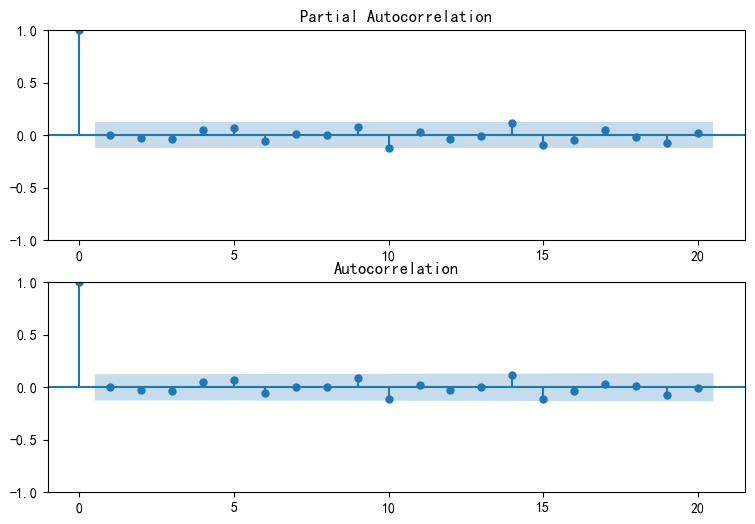

In [14]:
# 通过PACF图和ACF确定p和q值
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
plot_pacf(train_diff, lags=20, ax=ax1)
plot_acf(train_diff, lags=20, ax=ax2)
plt.show()

由ACF图和PACF图可知，p=10，q= 10。

In [15]:
# 根据ACF和PACF图选择参数，p=1, q=1
p, d, q = 10, 1, 10

## 五、模型训练

In [16]:
# 训练ARIMA模型
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  245
Model:               ARIMA(10, 1, 10)   Log Likelihood                -660.789
Date:                Wed, 17 Sep 2025   AIC                           1363.577
Time:                        14:08:05   BIC                           1437.018
Sample:                             0   HQIC                          1393.155
                                - 245                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.490     -0.844      0.398      -1.374       0.546
ar.L2         -0.3602      0.673     -0.535      0.592      -1.679       0.958
ar.L3          0.2355      0.835      0.282      0.7

## 六、模型评估

In [17]:
# 在测试集上进行预测
start_index = len(train)
end_index = len(train) + len(test) - 1
predictions = model_fit.predict(start=start_index, end=end_index, dynamic=False)

In [18]:
# 计算评估指标
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f"测试集MSE: {mse:.4f}")
print(f"测试集RMSE: {rmse:.4f}")
print(f"测试集MAE: {mae:.4f}")

测试集MSE: 23.5931
测试集RMSE: 4.8573
测试集MAE: 4.2927


## 七、模型预测

In [19]:
# 使用全部数据重新训练模型
full_model = ARIMA(ts, order=(p, d, q))
full_model_fit = full_model.fit()

# 预测未来7天
forecast = full_model_fit.forecast(steps=7)
forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=7)

## 八、可视化结果

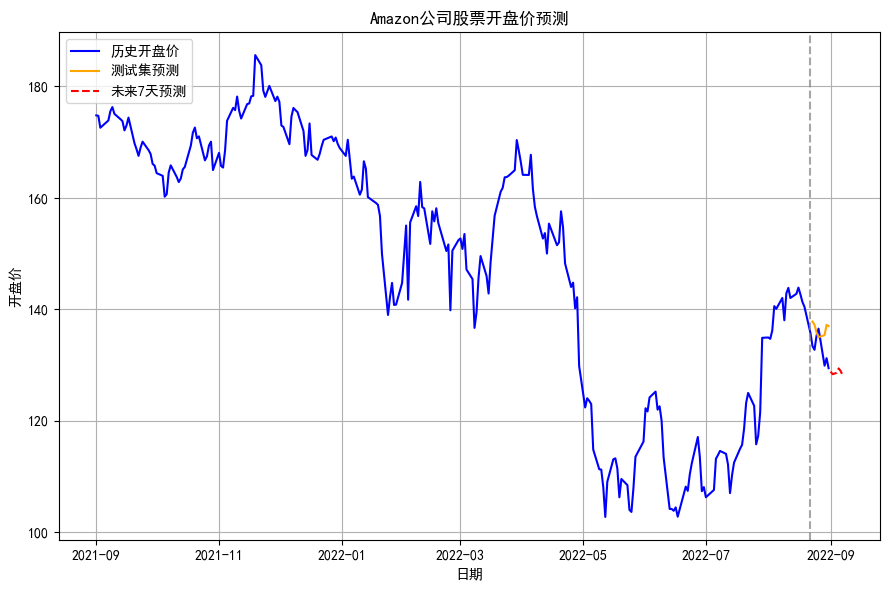

In [20]:
plt.figure(figsize=(9, 6))

# 绘制历史数据
plt.plot(ts.index, ts.values, label='历史开盘价', color='blue')

# 绘制测试集预测
plt.plot(test.index, predictions, label='测试集预测', color='orange')

# 绘制未来7天预测
plt.plot(forecast_index, forecast, label='未来7天预测', color='red', linestyle='--',)

# 添加图例和标签
plt.legend(loc='best')
plt.title(f'Amazon公司股票开盘价预测')
plt.xlabel('日期')
plt.ylabel('开盘价')
plt.grid(True)

# 添加垂直线标记训练集结束的位置
plt.axvline(x=ts.index[train_size-1], color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [21]:
# 打印预测结果
print("未来7天开盘价预测:")
for i, (date, value) in enumerate(zip(forecast_index, forecast)):
    print(f"第{i+1}天 ({date.strftime('%Y-%m-%d')}): {value:.2f}")

未来7天开盘价预测:
第1天 (2022-09-01): 128.84
第2天 (2022-09-02): 128.37
第3天 (2022-09-03): 128.49
第4天 (2022-09-04): 128.63
第5天 (2022-09-05): 129.41
第6天 (2022-09-06): 128.94
第7天 (2022-09-07): 128.10
